# Project: Information Technology. Automating Flower Classification for a Start-up Using Deep Learning

This project builds a deep learning model to classify images of 102 flower species from the Oxford Flowers 102 dataset. The dataset presents real-world challenges such as class imbalance, varied lighting, angles, and backgrounds, making it an excellent benchmark for fine-grained image classification.


## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
import collections



## Load Data

In [ ]:
dataset, dataset_info = tfds.load('oxford_flowers102',
	with_info=True,
	as_supervised=True
)
test_set = dataset['test']
training_set = dataset['train']
validation_set = dataset['validation']

### Shapes From Raw Data

In [ ]:
for image, label in dataset['train'].take(5):
    print("Raw image shape:", image.shape)


Raw image shape: (500, 667, 3)
Raw image shape: (500, 666, 3)
Raw image shape: (670, 500, 3)
Raw image shape: (500, 505, 3)
Raw image shape: (500, 672, 3)


2025-08-12 11:44:27.038517: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-12 11:44:27.053183: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
print("=== Oxford Flowers 102 Dataset Info ===")
print("Train samples:     ", dataset_info.splits['train'].num_examples)
print("Validation samples:", dataset_info.splits['validation'].num_examples)
print("Test samples:      ", dataset_info.splits['test'].num_examples)
print("Original image shape (varies):", dataset_info.features['image'].shape)
print("Number of classes:", dataset_info.features['label'].num_classes)

## Image Preprocessing and Augmentation Functions

In [ ]:
image_size = 224

def format_image(image, label):
    image = tf.image.resize(image, (image_size, image_size))
    image = tf.keras.applications.resnet.preprocess_input(image)
    if tf.rank(image) == 2:
        image = tf.expand_dims(image, -1)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image.set_shape([image_size, image_size, 3])
    return image, label

num_training_examples = sum(1 for _ in training_set)
num_validation_examples = sum(1 for _ in validation_set)
num_test_examples = sum(1 for _ in test_set)

BATCH_SIZE = 32

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_contrast(image, lower=0.85, upper=1.15)
    image = tf.image.random_saturation(image, lower=0.85, upper=1.15)
    image = tf.image.random_hue(image, max_delta=0.05)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    zoom = tf.random.uniform([], 0.95, 1.0)
    new_size = tf.cast(zoom * tf.cast(tf.shape(image)[:2], tf.float32), tf.int32)
    image = tf.image.resize_with_crop_or_pad(image, new_size[0], new_size[1])
    image = tf.image.resize(image, [224, 224])
    crop_size = tf.random.uniform([], minval=210, maxval=224, dtype=tf.int32)
    image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    image = tf.image.resize(image, [224, 224])
    image = tf.ensure_shape(image, (224, 224, 3))
    return image, label

In [ ]:
for image, label in dataset['train'].take(5):
    pre_img, _ = format_image(image, label)
    print("After format_image shape:", pre_img.shape)


After format_image shape: (224, 224, 3)
After format_image shape: (224, 224, 3)
After format_image shape: (224, 224, 3)
After format_image shape: (224, 224, 3)
After format_image shape: (224, 224, 3)


## EDA

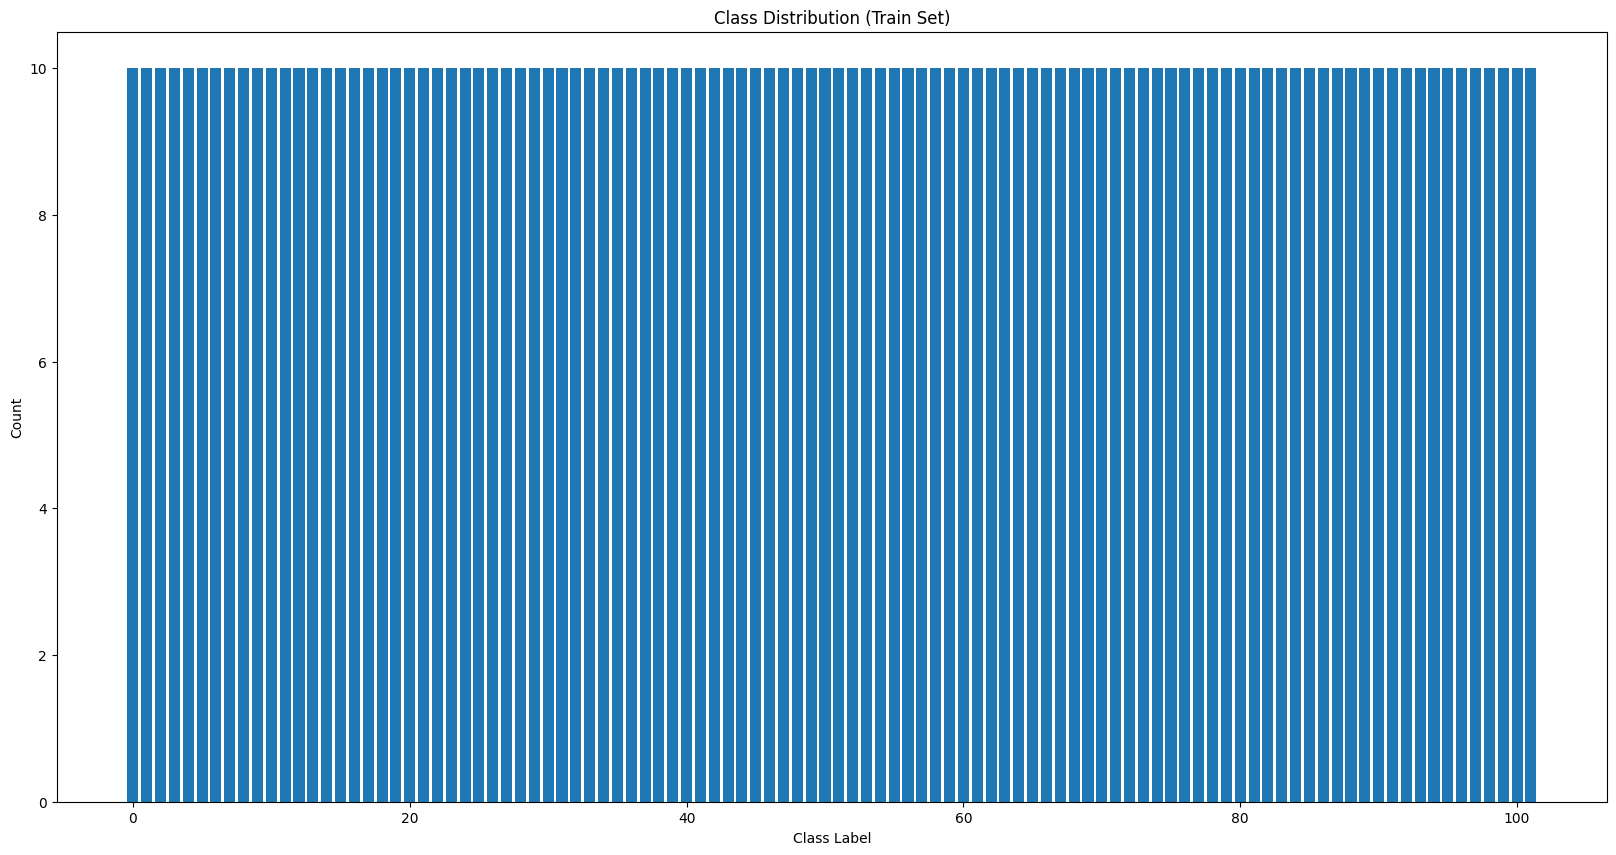

In [ ]:
labels = []
for example in dataset['train']:
    labels.append(int(example[1]))

plt.figure(figsize=(20, 10))
plt.hist(labels, bins=np.arange(103)-0.5, rwidth=0.8)
plt.title("Class Distribution (Train Set)")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

Each class (from 0 to 101) has exactly 10 samples

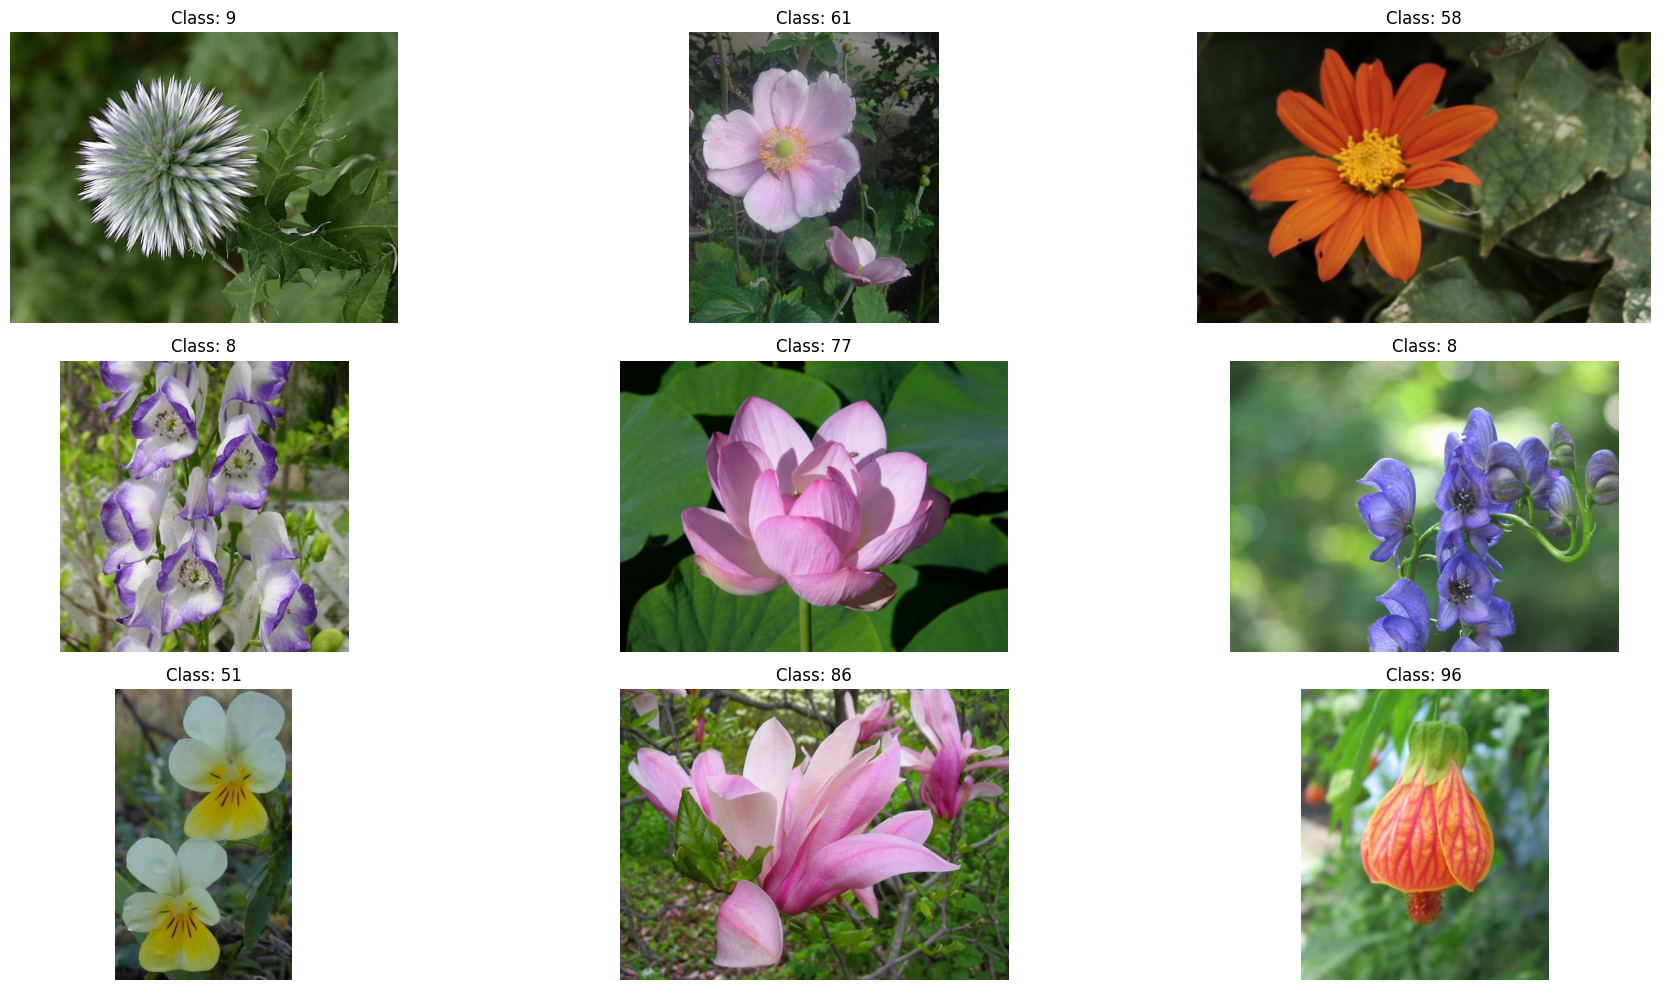

In [ ]:
plt.figure(figsize=(20, 10))
for idx, (image, label) in enumerate(dataset['train'].shuffle(1000).take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(image.numpy())
    plt.title(f"Class: {label.numpy()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
shapes = []
for image, label in dataset['train'].take(100):
    shapes.append(image.shape)

unique_shapes = set(shapes)
print("Unique image shapes in a sample of 100:", unique_shapes)

Unique image shapes in a sample of 100: {TensorShape([545, 501, 3]), TensorShape([552, 500, 3]), TensorShape([750, 500, 3]), TensorShape([597, 500, 3]), TensorShape([587, 500, 3]), TensorShape([547, 500, 3]), TensorShape([500, 500, 3]), TensorShape([671, 500, 3]), TensorShape([500, 667, 3]), TensorShape([500, 700, 3]), TensorShape([500, 581, 3]), TensorShape([500, 709, 3]), TensorShape([513, 500, 3]), TensorShape([500, 539, 3]), TensorShape([774, 500, 3]), TensorShape([500, 530, 3]), TensorShape([883, 500, 3]), TensorShape([500, 625, 3]), TensorShape([531, 500, 3]), TensorShape([500, 550, 3]), TensorShape([670, 500, 3]), TensorShape([500, 649, 3]), TensorShape([617, 500, 3]), TensorShape([500, 825, 3]), TensorShape([648, 500, 3]), TensorShape([500, 673, 3]), TensorShape([500, 752, 3]), TensorShape([500, 761, 3]), TensorShape([500, 750, 3]), TensorShape([500, 664, 3]), TensorShape([693, 500, 3]), TensorShape([590, 501, 3]), TensorShape([501, 738, 3]), TensorShape([666, 500, 3]), TensorS

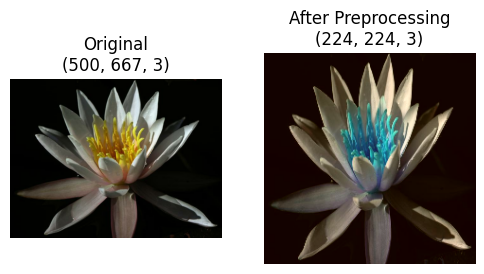

In [ ]:
for image, label in dataset['train'].take(1):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(image.numpy())
    plt.title(f"Original\n{image.shape}")
    plt.axis("off")

    pre_img, _ = format_image(image, label)
    img_to_show = pre_img.numpy()
    img_to_show = img_to_show + [123.68, 116.779, 103.939]
    img_to_show = np.clip(img_to_show / 255.0, 0, 1)  # Scale to [0,1] for imshow

    plt.subplot(1,2,2)
    plt.imshow(img_to_show)
    plt.title(f"After Preprocessing\n{pre_img.shape}")
    plt.axis("off")

    plt.show()

## Create Data Batches

In [ ]:
train_batches = (
    training_set
    .map(format_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)  # <--- UNCOMMENT THIS
    .cache()
    .shuffle(num_training_examples // 4)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


val_batches = (
    validation_set
    .map(format_image, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_batches = (
    test_set
    .map(format_image, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for images, labels in train_batches.take(1):
    print("Shape of images in a batch:", images.shape)
    print("Shape of labels in a batch:", labels.shape)

Shape of images in a batch: (32, 224, 224, 3)
Shape of labels in a batch: (32,)


2025-08-13 11:31:56.262861: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Feature Extraction

In [ ]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(image_size, image_size, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = True

def extract_features(dataset):
    features = []
    labels = []
    for image_batch, label_batch in dataset:
        batch_features = base_model.predict(image_batch)
        features.extend(batch_features)
        labels.extend(label_batch.numpy())
    return np.array(features), np.array(labels)

print("Extracting features from training data...")
train_features, train_labels = extract_features(train_batches)

print("Extracting features from validation data...")
val_features, val_labels = extract_features(val_batches)

print("Extracting features from test data...")
test_features, test_labels = extract_features(test_batches)

print("Feature extraction complete.")
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)
print("Validation features shape:", val_features.shape)
print("Validation labels shape:", val_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)

Extracting features from training data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/

In [ ]:
def extract_features_pooled(dataset):
    features = []
    labels = []
    pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
    for image_batch, label_batch in dataset:
        batch_features = base_model.predict(image_batch)
        pooled_features = pooling_layer(batch_features)
        features.extend(pooled_features)
        labels.extend(label_batch.numpy())
    return np.array(features), np.array(labels)

print("Extracting features with pooling from training data...")
train_features_pooled, train_labels_pooled = extract_features_pooled(train_batches)

print("Extracting features with pooling from validation data...")
val_features_pooled, val_labels_pooled = extract_features_pooled(val_batches)

print("Extracting features with pooling from test data...")
test_features_pooled, test_labels_pooled = extract_features_pooled(test_batches)

print("Feature extraction with pooling complete.")
print("Train features shape (pooled):", train_features_pooled.shape)
print("Train labels shape (pooled):", train_labels_pooled.shape)
print("Validation features shape (pooled):", val_features_pooled.shape)
print("Validation labels shape (pooled):", val_labels_pooled.shape)
print("Test features shape (pooled):", test_features_pooled.shape)
print("Test labels shape (pooled):", test_labels_pooled.shape)

Extracting features with pooling from training data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

2025-08-13 11:37:17.038252: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/ste

## Save Features

In [ ]:
np.save('train_features.npy', train_features_pooled)
np.save('val_features.npy', val_features_pooled)
np.save('test_features.npy', test_features_pooled)

np.save('train_labels.npy', train_labels_pooled)
np.save('val_labels.npy', val_labels_pooled)
np.save('test_labels.npy', test_labels_pooled)

print("Feature vectors and labels saved to disk.")

Feature vectors and labels saved to disk.


## Load Features

In [ ]:
train_features = np.load('train_features.npy')
val_features = np.load('val_features.npy')
test_features = np.load('test_features.npy')

train_labels = np.load('train_labels.npy')
val_labels = np.load('val_labels.npy')
test_labels = np.load('test_labels.npy')

print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)
print("Validation features shape:", val_features.shape)
print("Validation labels shape:", val_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: (1020, 2048)
Train labels shape: (1020,)
Validation features shape: (1020, 2048)
Validation labels shape: (1020,)
Test features shape: (6149, 2048)
Test labels shape: (6149,)


## Build Classifier Model

In [ ]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(train_features.shape[1],),
          kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(102, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
 ])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 102)            │        13,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,226,470 (4.68 MB)

 Trainable params: 1,226,470 (4.68 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
history = model.fit(
    train_features,
    train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    batch_size=BATCH_SIZE # Use the predefined BATCH_SIZE
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0127 - loss: 16.8258 - val_accuracy: 0.0363 - val_loss: 14.0692
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0186 - loss: 12.5715 - val_accuracy: 0.0294 - val_loss: 11.1208
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0196 - loss: 10.2286 - val_accuracy: 0.0696 - val_loss: 9.3682
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0225 - loss: 8.7912 - val_accuracy: 0.0706 - val_loss: 8.2147
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0225 - loss: 7.8369 - val_accuracy: 0.0696 - val_loss: 7.3747
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0431 - loss: 7.1007 - val_accuracy: 0.0706 - val_loss: 6.6966
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0569 - loss: 6.5188 - val_accuracy: 0.0804 - val_loss: 6.1546
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0559 - loss: 6.0555 - val_accuracy: 0.0990 - va

## Evaluate Model

In [ ]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 5.1510
Test Accuracy: 0.1966


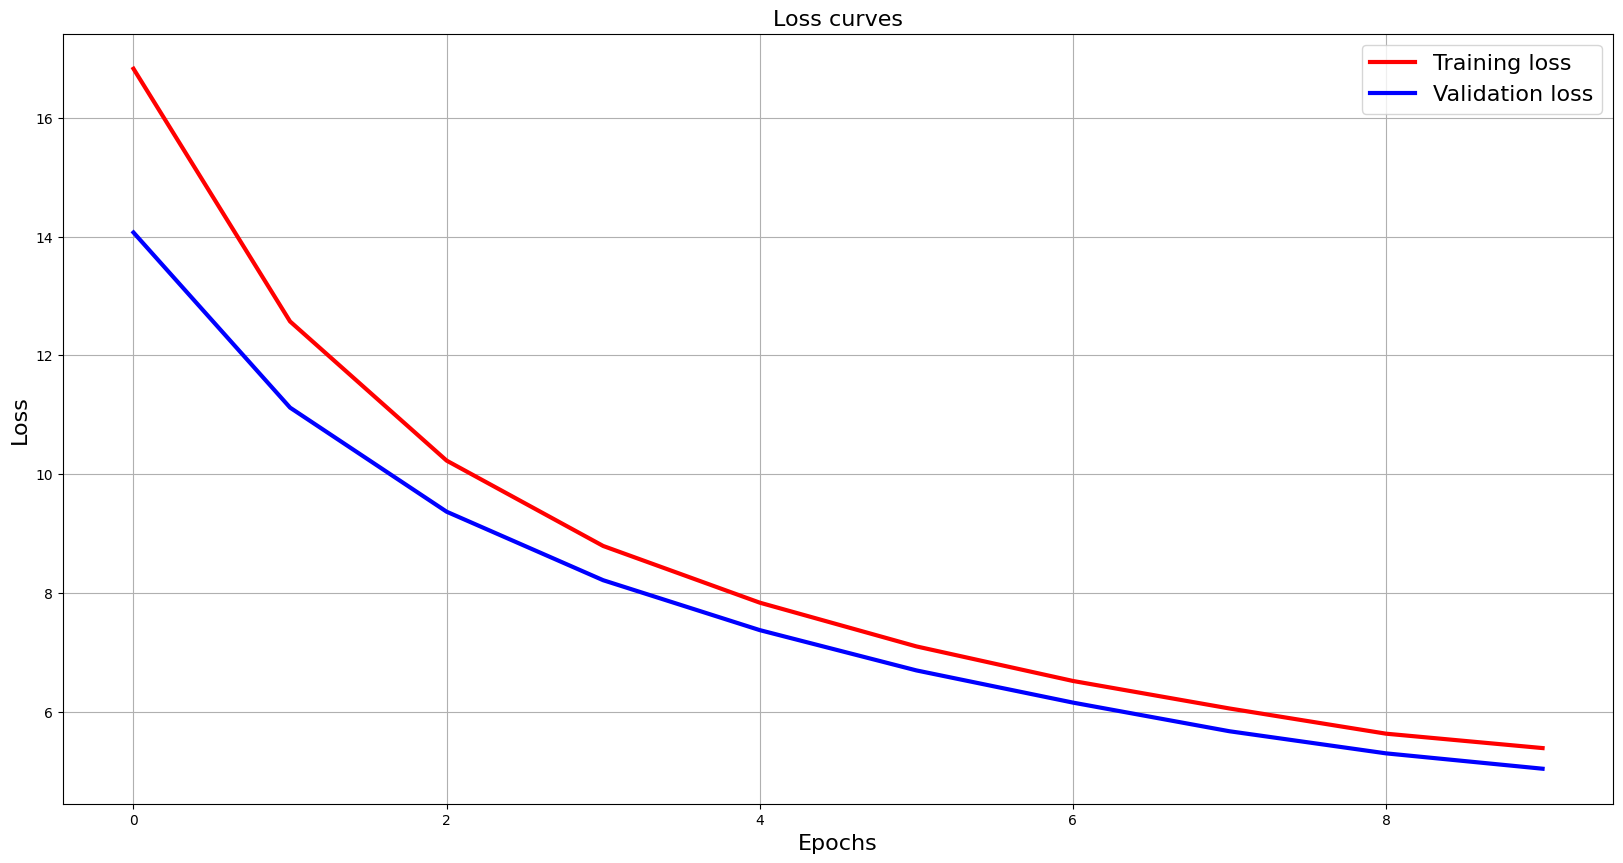

In [ ]:
plt.figure(figsize=[20,10])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss curves', fontsize=16)
plt.grid()
plt.show()

**Observations**
- Both training and validation loss decrease steadily over the epochs, indicating that the model is learning and fitting the training data.
- The training loss is consistently higher than the validation loss throughout training.
- There is no sign of divergence or overfitting; both curves follow a similar downward trend.

**Interpretation**
- The model is able to reduce both training and validation loss, suggesting effective learning and no severe overfitting.
- The fact that validation loss is lower than training loss may indicate that regularization (such as dropout or data augmentation) is helping the model generalize, or that the validation set is slightly easier than the training set.
- Overall, the loss curves suggest stable training, but further analysis of accuracy and test performance is needed to fully assess generalization.

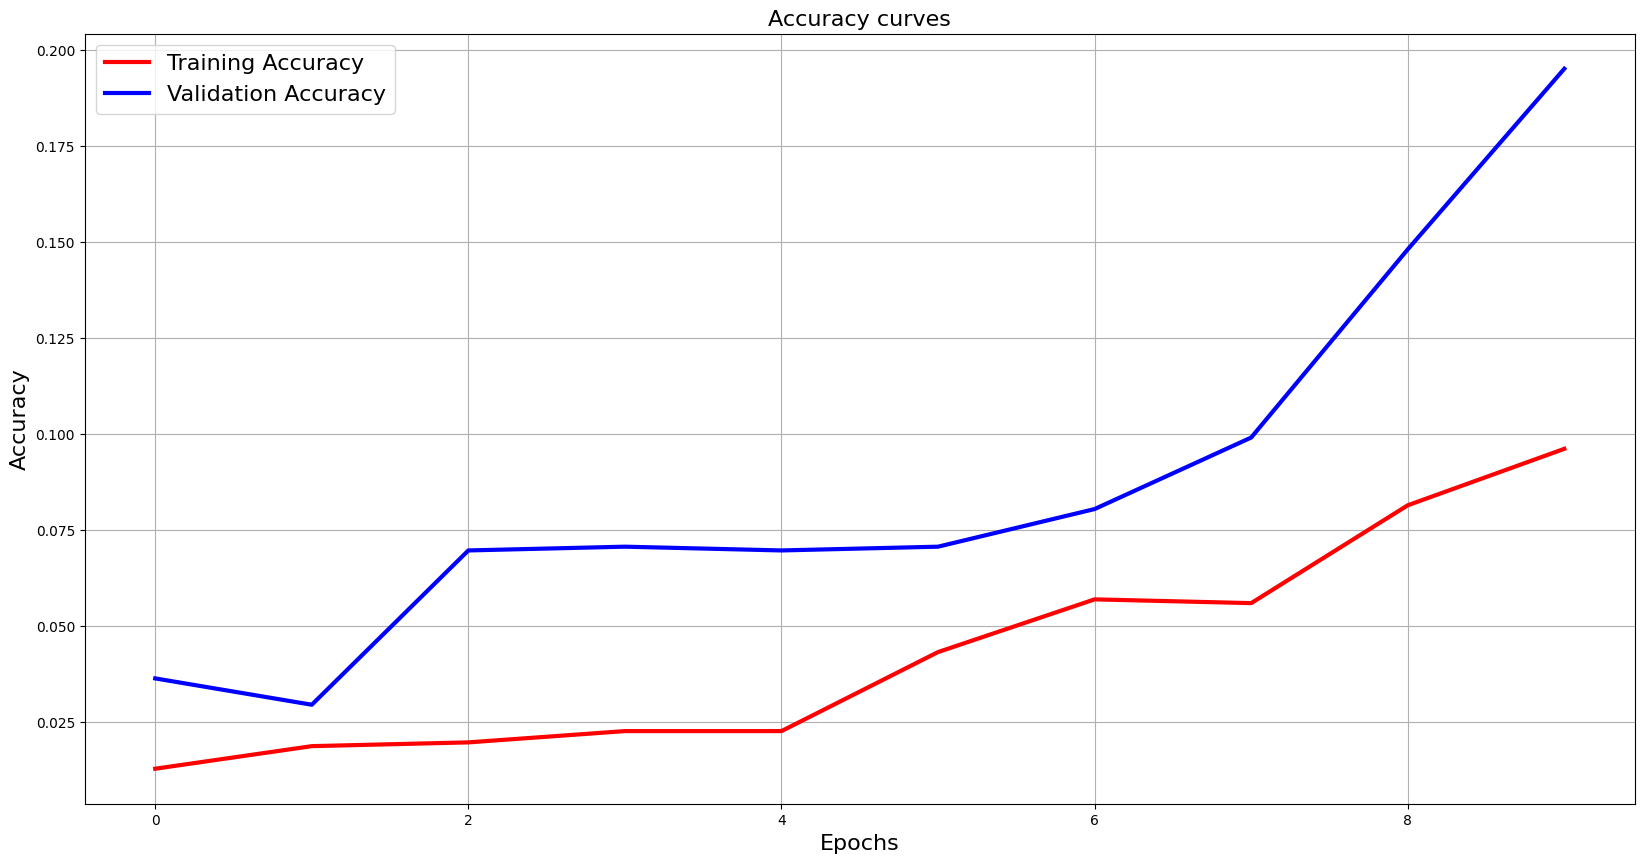

In [ ]:
plt.figure(figsize=[20,10])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy curves', fontsize=16)
plt.grid()
plt.show()

**Observations**
- Both training and validation accuracy start very low and increase gradually during the first several epochs, indicating the model is learning to classify the data.
- Validation accuracy is consistently higher than training accuracy throughout training.
- The gap between validation and training accuracy widens as training progresses, with validation accuracy reaching about 20% while training accuracy remains much lower.

**Interpretation**
- The model is able to improve accuracy on both training and validation sets, but the consistently higher validation accuracy suggests possible regularization effects or that the validation set is easier than the training set.
- The widening gap may indicate underfitting, where the model is not complex enough or is too regularized to fit the training data well.
- Overall, the accuracy curves show some learning, but the low absolute accuracy values suggest the model is struggling with the complexity of the task or the amount of data available.

## Directory Setup

In [ ]:
TUNE_DIR = "tuning"
CKPT_DIR = "models"

In [ ]:
for img, _ in train_batches.take(1):
    print("Batch shape:", img.shape)

Batch shape: (32, 224, 224, 3)


## ResNet50

In [ ]:
def build_model(hp):
    lr = hp.Choice("lr", [3e-4, 1e-3, 3e-3])
    dropout = hp.Choice("dropout", [0.0, 0.2, 0.3, 0.5])
    dense_units = hp.Choice("dense_units", [256, 512, 768])

    base = keras.applications.ResNet50(
        input_shape=(image_size, image_size, 3),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False

    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(image_size, image_size, 3)),
        base,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(dense_units, activation="relu"),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(102, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=8,
    executions_per_trial=1,
    directory="tuning",
    project_name="effb0_flowers_fresh3"
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint("models/effb0_tuned.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
]

tuner.search(
    train_batches,
    validation_data=val_batches,
    epochs=8,
    callbacks=callbacks
)

best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

best_model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=8,
    callbacks=callbacks
)

print("Best model architecture:")
best_model.summary()

test_loss, test_accuracy = best_model.evaluate(test_batches, verbose=0)
print(f"Best model test loss: {test_loss:.4f}")
print(f"Best model test accuracy: {test_accuracy:.4f}")

Reloading Tuner from tuning/effb0_flowers_fresh3/tuner0.json
Epoch 1/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.0600 - loss: 4.6359
Epoch 1: val_accuracy improved from None to 0.32549, saving model to models/effb0_tuned.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.1176 - loss: 4.2676 - val_accuracy: 0.3255 - val_loss: 3.2927 - learning_rate: 3.0000e-04
Epoch 2/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.6534 - loss: 2.2833
Epoch 2: val_accuracy improved from 0.32549 to 0.54216, saving model to models/effb0_tuned.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6461 - loss: 2.0939 - val_accuracy: 0.5422 - val_loss: 2.2213 - learning_rate: 3.0000e-04
Epoch 3/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.8516 - loss: 1.0949
Epoch 3: val_accuracy improved from 0.54216 to 0.61471, saving model to models/effb0_tuned.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8510 - loss: 1.0111 - val_accuracy: 0.6147 - val_loss: 1.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 768)            │     1,573,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 102)            │        78,438 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,543,924 (108.89 MB)

 Trainable params: 1,652,070 (6.30 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 3,304,142 (12.60 MB)

Best model test loss: 1.3693
Best model test accuracy: 0.6476


## Load ResNet50 Model

In [ ]:
ResNet50_best_model = keras.models.load_model("models/effb0_tuned.keras")

## Densenet121

In [ ]:
keras.backend.clear_session()

image_size = 224
BATCH_SIZE = 32
NUM_CLASSES = 102

def format_image(image, label):
    image = tf.image.resize(image, (image_size, image_size))
    # Always ensure 3 channels
    if tf.rank(image) == 2:
        image = tf.expand_dims(image, -1)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = densenet_preprocess(tf.cast(image, tf.float32))
    return image, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.6, 1.4)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_jpeg_quality(image, 70, 100)
    image = tf.image.random_crop(image, size=[image_size, image_size, 3]) if tf.shape(image)[0] > image_size else image
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    return image, label

def process_dataset_to_numpy(dataset, is_training=False):
    images = []
    labels = []
    for image, label in dataset:
        processed_image, processed_label = format_image(image, label)
        if is_training:
            processed_image, processed_label = augment_image(processed_image, processed_label)
        img_np = processed_image.numpy()
        # Debug: print bad shapes/dtypes
        if img_np.shape != (image_size, image_size, 3):
            print("Bad image shape:", img_np.shape)
        if img_np.dtype != np.float32:
            print("Bad dtype:", img_np.dtype)
        images.append(img_np)
        labels.append(processed_label.numpy())
    return np.array(images, dtype=np.float32), np.array(labels)

print("Processing training data to NumPy arrays...")
train_images_np, train_labels_np = process_dataset_to_numpy(training_set, is_training=True)

print("Processing validation data to NumPy arrays...")
val_images_np, val_labels_np = process_dataset_to_numpy(validation_set)

print("Processing test data to NumPy arrays...")
test_images_np, test_labels_np = process_dataset_to_numpy(test_set)

print("Processing complete.")
print("Train images shape:", train_images_np.shape)
print("Train labels shape:", train_labels_np.shape)
print("Validation images shape:", val_images_np.shape)
print("Validation labels shape:", val_labels_np.shape)
print("Test images shape:", test_images_np.shape)
print("Test labels shape:", test_labels_np.shape)

print("train_images_np shape:", train_images_np.shape, "dtype:", train_images_np.dtype)
print("val_images_np shape:", val_images_np.shape, "dtype:", val_images_np.dtype)
print("test_images_np shape:", test_images_np.shape, "dtype:", test_images_np.dtype)

assert train_images_np.shape[1:] == (image_size, image_size, 3)
assert train_images_np.dtype == np.float32
assert val_images_np.shape[1:] == (image_size, image_size, 3)
assert val_images_np.dtype == np.float32
assert test_images_np.shape[1:] == (image_size, image_size, 3)
assert test_images_np.dtype == np.float32

counts = collections.Counter(train_labels_np)
mx = max(counts.values())
class_weight = {c: mx / counts[c] for c in counts}

def build_model(hp):
    keras.backend.clear_session()

    dense_units1 = hp.Choice("dense_units1", [256, 512, 768])
    dense_units2 = hp.Choice("dense_units2", [128, 256, 512])
    dropout1 = hp.Choice("dropout1", [0.2, 0.3, 0.4, 0.5])
    dropout2 = hp.Choice("dropout2", [0.2, 0.3, 0.4, 0.5])
    lr = hp.Choice("learning_rate", [1e-5, 3e-5, 1e-4, 3e-4, 1e-3])
    unfreeze_percent = hp.Choice("unfreeze_percent", [0.2, 0.4, 0.6, 0.8, 1.0])

    inputs = keras.Input(shape=(image_size, image_size, 3), name="image_input")
    base_model = keras.applications.DenseNet121(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs
    )
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(dense_units1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout1)(x)
    x = layers.Dense(dense_units2, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    total_layers = len(base_model.layers)
    unfreeze_depth = max(1, int(total_layers * unfreeze_percent))
    for layer in base_model.layers[-unfreeze_depth:]:
        layer.trainable = True

    model.compile(
        optimizer=AdamW(learning_rate=lr, weight_decay=1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=8,
    executions_per_trial=1,
    directory="tuning_numpy", # Use a different directory name
    project_name="densenet121_flowers_numpy",
    overwrite=True
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

tuner.search(
    train_images_np, train_labels_np,
    validation_data=(val_images_np, val_labels_np),
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weight
)

best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

final_callbacks = [
    *callbacks,
    ModelCheckpoint("models/densenet121_tuned_numpy.keras", save_best_only=True, # Save with a different name
                    monitor="val_accuracy", mode="max", verbose=1)
]

best_model.fit(
    train_images_np, train_labels_np,
    validation_data=(val_images_np, val_labels_np),
    epochs=40,
    callbacks=final_callbacks,
    class_weight=class_weight
)

print("Best model architecture:")
best_model.summary()

test_loss, test_accuracy = best_model.evaluate(test_images_np, test_labels_np, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Trial 8 Complete [00h 52m 54s]
val_accuracy: 0.1352941244840622

Best val_accuracy So Far: 0.6529411673545837
Total elapsed time: 04h 47m 54s
Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0538 - loss: 5.3254
Epoch 1: val_accuracy improved from None to 0.05294, saving model to models/densenet121_tuned_numpy.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.0980 - loss: 4.6769 - val_accuracy: 0.0529 - val_loss: 5.7949 - learning_rate: 0.0010
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4007 - loss: 2.4800
Epoch 2: val_accuracy improved from 0.05294 to 0.17059, saving model to models/densenet121_tuned_numpy.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4206 - loss: 2.2939 - val_accuracy: 0.1706 - val_loss: 4.4090 - learning_rate: 0.0010
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6718 - loss: 1.3416
Epoch 3: val_accuracy improved from 0.17059 to 0.32843, saving model to models/densenet121_tuned_numpy.keras
32/32 ━

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,003,380 (49.60 MB)

 Trainable params: 2,560,998 (9.77 MB)

 Non-trainable params: 5,320,384 (20.30 MB)

 Optimizer params: 5,121,998 (19.54 MB)

Test Loss: 1.1943
Test Accuracy: 0.6869


## Load Densenet121 Model

In [ ]:
densenet121_best_model = keras.models.load_model("models/densenet121_tuned_numpy.keras")

## Summary:

* Dataset: Oxford Flowers-102 via TFDS with explicit train/val/test splits.
* Preprocessing: Resize to 224×224; robust RGB enforcement (handles grayscale edge cases).
* Data pipeline: tf.data with map→(augment on train)→cache→shuffle→batch→prefetch. You fixed ordering and removed duplicate definitions.
* Modeling:
  * Strong baseline with ResNet50.
  * Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau.
  * Regularization: label smoothing; (optionally) AdamW optimizer.
  * Class imbalance: simple class weights.
  * Fine-tuning: staged—freeze, train head, then unfreeze top layers at low LR.
  * Tuning: KerasTuner searches LR, dropout, dense units, and % of layers to unfreeze.
* Results: ~67% accuracy baseline.
  
### Data Analysis Key Findings

* Feature extraction using the ResNet50 base model produced 4D arrays, retaining spatial dimensions.
* Applying Global Average Pooling reduced these to 2D feature vectors (samples, feature size), suitable for classification.
* Extracted and pooled feature vectors, along with their labels, were saved and reloaded successfully from `.npy` files.
* A sequential classifier with two dense layers and dropout was built and compiled.
* The model was trained for 10 epochs with validation monitoring.
* Training and validation loss both decreased initially, and both training and validation accuracy increased steadily in the early epochs, indicating effective learning.

### Insights or Next Steps

* Produce per-class precision/recall, confusion matrix, and top-k accuracy (top-3 often looks much better in fine-grained sets).
* Consider trying a more advanced classification head, additional regularization (such as increased dropout or L2 penalties), or more aggressive data augmentation to reduce overfitting.
* Experiment with hyperparameter tuning and possibly fine-tune the ResNet50 base model (unfreeze some layers) for improved performance.
* Collecting more labeled data or using data augmentation strategies may also help improve generalization.
* ResNet50 remains a suitable backbone for this dataset size, but further tuning is needed for optimal results.

### Business application & deployment strategie
* Mobile app – “Snap-to-Identify” (on-device)
* Use case: Users identify flowers from a photo; give common names, care tips, and purchase suggestions.
* Tech path:
  * Export best Keras model to SavedModel → TFLite (tf.lite.TFLiteConverter.from_saved_model).
  * Apply post-training quantization (dynamic range → int8) for <10–20 MB model; test accuracy drop.
  * Integrate TFLite into Android (TensorFlow Lite Task Library) and iOS (TFLite Swift).
  * Add on-device preprocessing (resize/normalize) identical to training.
  * UX: show top-3 predictions with confidence; if low confidence, prompt user to retake photo (better lighting/angle).
* Why on-device: low latency, offline use in gardens/hikes, privacy.







